D MODEL
========
This model is really similar to the A model. But instead of using word embeddings we are using char embeddings.

Initialization of the Environment
==========================

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import collections
import tensorflow as tf
import os

np.random.seed(1)
tf.set_random_seed(2)

Load Data
========

In [0]:
import xml.etree.ElementTree as ET
import csv
import pandas as pd

In [0]:
SST_HOME='drive/My Drive/Colab Notebooks/Erisk2019/'
path_train=SST_HOME+'datas/training data - t1/2018 train/train.csv'
path_test=SST_HOME+'datas/training data - t1/2018 test/test.csv'

In [0]:
def listdir_fulllpath(d):
  return [os.path.join(d, f) for f in os.listdir(d)]

In [0]:
def parse_subject(path_xml):
  """
  This function will take the xmls return a pandas df.
  """
  tree = ET.parse(path_xml)
  root = tree.getroot()
  
  subject_id = root.find('ID').text
  writings = []
  
  # Read the xml
  for writing in root.findall('WRITING'):
    writing_data = {}
    writing_data['ID'] = subject_id
    writing_data['TITLE'] = writing.find('TITLE').text
    writing_data['DATE'] = writing.find('DATE').text
    writing_data['INFO'] = writing.find('INFO').text 
    writing_data['TEXT'] = writing.find('TEXT').text
    
    writings.append(writing_data)
    
  df = pd.DataFrame(writings)
  # If the record has no id or date return none
  try:
    df = df.set_index(['ID', 'DATE'])
  except:
    return None
  
  return df


def parse_folder(path_folder):
  """
  This function will parse a whole folder worth of records.
  
  Returns the records as a csv.
  """
  # Look for all the files in the directory
  files = []
  for f in os.listdir(path_folder):
      file_path = os.path.join(path_folder, f)
      if os.path.isfile(file_path):
        files.append(file_path)
  
  # Parse the xmls to pandas dataframes
  frames = [parse_subject(f) for f in files]
  
  # Merge the frames
  return pd.concat(frames)
  
def records_to_csv(path_records, path_csv, load=False):
  """
  This function will parse all the records into a csv
  """
  if load:
    if os.path.exists(path_csv):
      return pd.read_csv(path_csv).set_index(['ID', 'DATE'])
    else:
      print("File not found, can't load")
    
  
  frames = []
  test = False
  for f in listdir_fulllpath(path_records):
    
    # check if it is a test folder.
    if 'test' in f:
      test = True
      
    if os.path.isdir(f):
      for j in listdir_fulllpath(f):
        if os.path.isdir(j):
          frames.append(parse_folder(j))
          
  df = pd.concat(frames).sort_index()
  
  with open(path_records + 'risk_golden_truth.txt' if not test else path_records + 'risk-golden-truth-test.txt') as gt:
    df["LABEL"] = np.nan
    for line in gt:
      
      # The file ends with a newline, dont really know why
      if line == '\n':
        break
      
      rec_id, value = line.split()

      df.loc[rec_id, 'LABEL'] = value
      
  df.to_csv(path_csv)
  return df

In [7]:
print('started')
train_df = records_to_csv(SST_HOME+'datas/training data - t1/2018 train/', path_train, load=True)
print('completed train')
test_df = records_to_csv(SST_HOME+'datas/training data - t1/2018 test/', path_test, load=True)
print('completed test')

started
completed train
completed test


In [8]:
print(len(test_df), len(train_df))

168507 84834


In [9]:
train_df.columns

Index(['INFO', 'TEXT', 'TITLE', 'LABEL'], dtype='object')

In [0]:
train_x = [text + title for text, title in train_df[["TEXT", "TITLE"]].values]
train_y = train_df["LABEL"].values

test_x = [text + title for text, title in test_df[["TEXT", "TITLE"]].values]
test_y = test_df["LABEL"].values

In [11]:
train_balance = collections.Counter(train_y)
test_balance = collections.Counter(test_y)

print(train_balance)
print(test_balance)

Counter({0: 77382, 1: 7452})
Counter({0: 151085, 1: 17422})


Tokenizing the texts
================

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words=stopwords.words('english')
# Define maximum vocabulary length
MAX_WORDS = 5000

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# We are using this function to clean the test set
def tokenize_clean_text(text, tfidf=True, tokenizer=None, max_length=None, max_words=MAX_WORDS):
  """
  This function is in charge of tokenizing the text it is given. It also cleans
  the text from stop-words, punctuation, and gives a special token to numbers.
  
  :param text: The texts to tokenize in a bidimensional python array.
  
  :returns: The tokenized and cleaned text in a bidimensional python array.
            The tokenizer used to preprocess the text.
            The maximum length used for padding.
  """   
  # set [removed] as a special token
  text_removed = [t.replace("[removed]", "R3MOV3D") for t in text]
  
  # We remove the numbers
  cropped_numbers_text = [" ".join([word if not word.isdigit() else ""
                                for word in sentence.split()])
                               for sentence in text_removed]
  
  # Delete stopwords as well as every word less than 3 chars.
  cropped_numbers_stopw_text = [" ".join([word if not (word in stop_words or len(word) <= 3) else ""
                                      for word in sentence.split()])
                                     for sentence in cropped_numbers_text]
  
  if tfidf:
    vec = TfidfVectorizer(max_features=max_words)
    tfidf_mat = vec.fit_transform(cropped_numbers_stopw_text).toarray()
    tfid_words = vec.get_feature_names()

    cropped_numbers_stopw_tfidf_text = [" ".join([word if word in tfid_words else ""
                                            for word in sentence.split()])
                                            for sentence in cropped_numbers_stopw_text]
  
  if tokenizer is None:
    tokenizer = Tokenizer(num_words=max_words) # They use 5k words too
    tokenizer.fit_on_texts(cropped_numbers_stopw_tfidf_text if tfidf else cropped_numbers_stopw_text)
  # We tokenize the sentences
  tokenized_text = tokenizer.texts_to_sequences(cropped_numbers_stopw_tfidf_text if tfidf else cropped_numbers_stopw_text)
  
  if max_length == None:
    max_length = 0
    for sentence in tokenized_text:
      max_length = max_length if len(sentence) < max_length else len(sentence)
  
  # Now we return the padded the sequences.
  return pad_sequences(tokenized_text, max_length), tokenizer, max_length, cropped_numbers_stopw_tfidf_text if tfidf else cropped_numbers_stopw_text
  

In [0]:
train_x_token, tokenizer, max_length, train_x_clean = tokenize_clean_text(train_x) 
test_x_token, _, _, test_x_clean = tokenize_clean_text(test_x, tokenizer=tokenizer)

In [0]:
token_index = np.unique(train_x_token)

In [0]:
max_words = len(token_index)

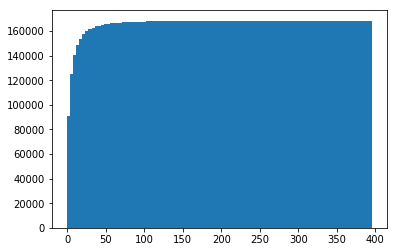

In [17]:
import matplotlib.pyplot as plt

lengths  = np.array([len(sentence.split()) for sentence in test_x_clean if len(sentence.split()) < 400])
plt.hist(lengths, bins=100, cumulative = True)
plt.show()

In [0]:
### We keep this as a reference
#the length will be set to 50
#max_length = 50
#train_x_crop = train_x_clean[:, -max_length:]
#test_x_crop = test_x_clean[:, -max_length:]

In [0]:
train_x_char = [[c for c in instance] for instance in train_x_clean]
test_x_char = [[c for c in instance] for instance in test_x_clean]

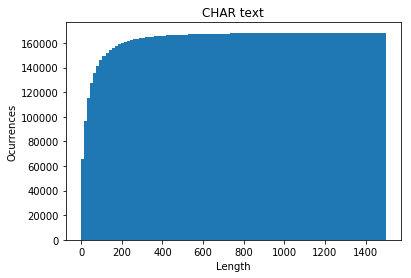

In [20]:
lengths = np.array([len(sentence) for sentence in test_x_char if len(sentence) < 1500])
plt.hist(lengths, bins=100, cumulative=True)
plt.title("CHAR text")
plt.xlabel("Length")
plt.ylabel("Ocurrences")
plt.savefig(SST_HOME + 'd_text_hist.eps', metadata="eps")

In [0]:
# the length will be set to 400
max_length = 400
train_x_char_padded = [["."]*(max_length - len(instance)) + instance if len(instance) < max_length else instance for instance in train_x_char]
test_x_char_padded = [["."]*(max_length - len(instance)) + instance if len(instance) < max_length else instance for instance in test_x_char]

train_x_char_crop = [instance[-max_length:] for instance in train_x_char_padded]
test_x_char_crop = [instance[-max_length:] for instance in test_x_char_padded]

In [0]:
def tokenize_chars(text, tokenizer=None, max_length=max_length):
  if tokenizer is None:
    tokenizer = Tokenizer() # They use 5k words too
    tokenizer.fit_on_texts(text)
  # We tokenize the sentences
  tokenized_text = tokenizer.texts_to_sequences(text)
  
  for i, t in enumerate(tokenized_text):
    if len(t) < max_length:
      tokenized_text[i] = [1] * (max_length - len(t)) + tokenized_text[i]
      
  return tokenized_text, tokenizer

In [0]:
train_x_char_crop_token, char_tokenizer = tokenize_chars(train_x_char_crop)
test_x_char_crop_token, _ = tokenize_chars(test_x_char_crop, char_tokenizer)

In [24]:
# Save the tokenizer for test stage pruposes
import joblib

PATH_TOKENIZER = SST_HOME + "DL/char_tokenizer.pkl"

joblib.dump(char_tokenizer, PATH_TOKENIZER)

['drive/My Drive/Colab Notebooks/Erisk2019/DL/char_tokenizer.pkl']

Neural networks
=============

In [0]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Activation, Embedding, Dropout, Input
from keras.layers import Lambda, Flatten, RepeatVector, Permute, Multiply
from keras.layers import LSTM, GRU, Bidirectional, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Concatenate

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop, Adam

# **TensorBoard**
TensorBoard is a great tool for DL visualization. It shows the evolution of metrics during the training phase, as well as the weights, distributions, and even the graph of the neural net. 

We will be using tensorboardcolab in order to run a 
TensorBoard instance. This will initialize a ngrok machine and launch TensorBoard for us to see. 

TensorBoard will be accesible by the url 

In [26]:
# We install tensorboard colab in case we don't have it already.
!pip install tensorboardcolab

In [27]:
import tensorboardcolab as tb

tbc=tb.TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://38ac66e5.ngrok.io


Experiments Configuration
=====================

In [0]:

tfidf = [True]
concept_emb = [True]
load_emb = [False]
num_classes = [None]
emb_size = [50]
trainable_emb = [True]
cnn_size = [[64], [128]]
cnn_filter = [[3], [10], [3, 14]]
rnn_size = [[None]]
cell_type = [LSTM]
bidirectional = [False]
attention = [False]
dropout = [0.5]
dnn_size = [[64], [32]]
batch_size = [1024]

indexes = ["load_emb", "emb_size", "trainable_emb", "cnn_size", "cnn_filter", "rnn_size", "cell_type", "bidirectional", "attention", "dropout", "dnn_size", "batch_size"]
param   = [load_emb, emb_size, trainable_emb, cnn_size, cnn_filter, rnn_size, cell_type, bidirectional, attention, dropout, dnn_size, batch_size]

In [0]:
import itertools

def combine_params(param, indexes):
  """
  This function is in charge of combining the parameters. This way we can perform a grid search automatically.
  
  Inputs: The array of different parameters, and the indexes for them.
  
  Outputs: The dictionary of different configurations made.
  """
  combinations = list(itertools.product(*param))
  param_combinations = [{k:v for k, v in zip(indexes, combination)}  for combination in combinations]
  for p in param_combinations:
    # The embeddings size must adapt to the embeddings loaded.
    if p["load_emb"]:
      p["emb_size"] = None
    else:
      p["embedding_matrix"] = None
  return param_combinations

In [0]:
network_parameters = combine_params(param, indexes)

In [0]:
# We change the number of classes automatically
for p in network_parameters:
  p["max_length"] = max_length
  p["max_words"] = max_words
  try:
    p["num_classes"] = train_y.shape[1]
  except IndexError:
    p["num_classes"] = 1

Neural Network
=============

In [0]:
def add_embeddings(z, load, size, trainable, vocab_size, max_length, embedding_matrix): 
  """
  This method adds embeddings to the network.
  
  Returns the net with the embeddings added.
  """
  if load:
    z = Embedding(vocab_size, size, input_length=max_length, weights=[embedding_matrix], trainable=trainable)(z)
  else:
    z = Embedding(vocab_size, size, input_length=max_length)(z)
    
  return z

def add_cnn(z, size, filter_sizes, flatten):
  """
  This method adds the CNN layers to the network.
  
  Returns the net with the CNN layers.
  """
  conv_blocks = []
  for filter_size in filter_sizes:
    if filter_size is None:
      return z
    conv = None
    for i, cnn_layer in enumerate(size):
      if cnn_layer is None:
        return z
      conv = Conv1D(cnn_layer, filter_size, padding='valid', activation='relu', strides=1)(z if conv is None else conv)
      # if (i + 1)  % 2 == 0:
      conv = MaxPooling1D(pool_size=filter_size)(conv)        
      
    if flatten:
      conv = Flatten()(conv)
    conv_blocks.append(conv)         
 
  z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
  
  return z

def add_rnn(z, size, bidirectional, cell_type, attention):
  """
  This method adds the RNN layers to the network. It also adds an attention layer if intended.
  
  Returns the net with the RNN & Attention added.
  """
  for i, rsz in enumerate(size):
    if rsz is None:
      return z
    if not bidirectional:
      if i < len(size) - 1:
        z = cell_type(rsz, return_sequences=True)(z)
      else:
        z = cell_type(rsz, return_sequences=attention)(z)
    else:
      if i < len(size) - 1:
        z = Bidirectional(cell_type(rsz, return_sequences=True))(z)
      else:
        z = Bidirectional(cell_type(rsz, return_sequences=attention))(z)

  if attention:
    z = add_attention(z)

  return z

def add_dnn(z, size, dropout, activation="relu"):
  """
  This method adds the DNN layers to the network.
  
  Returns the net with the DNN layers added.
  """
  for fsz in size:
    if fsz is None:
      return z

    z = Dense(fsz, activation=activation)(z)
    z = Dropout(dropout)(z)
    
  return z

def add_attention(activations):
  """
  This method adds an attention layer.
  
  Returns the model with the attention layer.
  """
  
  size =  K.int_shape(activations)[-1]
  attention = BatchNormalization()(activations)
  attention = Dense(1, activation='tanh')(attention)
  attention = Flatten()(attention)
  attention = Activation('softmax')(attention)
  attention = RepeatVector(size)(attention)
  attention = Permute([2, 1])(attention)
  
  z = Multiply()([activations, attention])
  z = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(size,))(z)

  return z

In [0]:
def create_model(params):
  """
  This method creates a network model with the parameters given.
  
  Returns the uncompiled model.
  """
  inputs = Input(name='inputs',shape=(params["max_length"],))
  
  z = add_embeddings(inputs, params["load_emb"], params["emb_size"], params["trainable_emb"], params["max_words"] ,params["max_length"], params["embedding_matrix"])
  
  z = add_cnn(z, params["cnn_size"], params["cnn_filter"], [None] == params["rnn_size"])
  
  z = add_rnn(z, params["rnn_size"], params["bidirectional"], params["cell_type"], params["attention"])
  
  z = add_dnn(z, params["dnn_size"], params["dropout"])
  
  outputs = Dense(params["num_classes"], activation='sigmoid', name='output_layer')(z)
  
  net_model = Model(inputs=inputs,outputs=outputs)
  
  return net_model

In [0]:
def create_models(network_parameters, verbose=False):
  model_list = []
  for net_p in network_parameters:
    m = create_model(net_p)
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    model_list.append(m)
    
    if verbose:
      m.summary()
      
  return model_list

In [35]:
model_list = create_models(network_parameters, verbose=True)

W0625 14:07:17.597585 140130861967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 14:07:17.609679 140130861967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 14:07:17.611827 140130861967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 14:07:17.662487 140130861967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0625 14:07:17.690973 140130861967232 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 50)           225950    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 64)           9664      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 132, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8448)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                540736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [36]:
network_parameters

[{'attention': False,
  'batch_size': 1024,
  'bidirectional': False,
  'cell_type': keras.layers.recurrent.LSTM,
  'cnn_filter': [3],
  'cnn_size': [64],
  'dnn_size': [64],
  'dropout': 0.5,
  'emb_size': 50,
  'embedding_matrix': None,
  'load_emb': False,
  'max_length': 400,
  'max_words': 4519,
  'num_classes': 1,
  'rnn_size': [None],
  'trainable_emb': True},
 {'attention': False,
  'batch_size': 1024,
  'bidirectional': False,
  'cell_type': keras.layers.recurrent.LSTM,
  'cnn_filter': [3],
  'cnn_size': [64],
  'dnn_size': [32],
  'dropout': 0.5,
  'emb_size': 50,
  'embedding_matrix': None,
  'load_emb': False,
  'max_length': 400,
  'max_words': 4519,
  'num_classes': 1,
  'rnn_size': [None],
  'trainable_emb': True},
 {'attention': False,
  'batch_size': 1024,
  'bidirectional': False,
  'cell_type': keras.layers.recurrent.LSTM,
  'cnn_filter': [10],
  'cnn_size': [64],
  'dnn_size': [64],
  'dropout': 0.5,
  'emb_size': 50,
  'embedding_matrix': None,
  'load_emb': False,

# TB Colab Callback
We rewrite the tensorboardcolab callbacks to create different sessions depending on the variables our trainings have. This helps to differentiate the models in tensorboard.

In [0]:
import os
from keras.callbacks import TensorBoard
import tensorflow as tf

class TensorBoardColabCallback(TensorBoard):
    def __init__(self, tbc=None, write_graph=True, name=None, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'

        if tbc is None:
            return

        log_dir = tbc.get_graph_path()

        training_log_dir = os.path.join(log_dir, 'training_{}'.format(name))
        super(TensorBoardColabCallback, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation_{}'.format(name))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TensorBoardColabCallback, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}

        for name, value in val_logs.items():
            # print('val_logs:',epoch, name, value)
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TensorBoardColabCallback, self).on_epoch_end(epoch, logs)
        
    def on_train_end(self, logs=None):
        super(TensorBoardColabCallback, self).on_train_end(logs)
        self.val_writer.close()

tb.TensorBoardColabCallback = TensorBoardColabCallback

In [0]:
def define_callbacks(name):
  # Define the callbacks
  tbc_callback = tb.TensorBoardColabCallback(tbc, name=name)  # , histogram_freq=1)
   
  callbacks = [
      ReduceLROnPlateau(),
      EarlyStopping(patience=1),
      tbc_callback
  ]
  return callbacks

In [0]:
# Create an array of names
network_names = []
for p in network_parameters:
  name = "load_emb_{}_num_classes_{}_emb_size_{}_trainable_emb_{}_cnn_size_{}_cnn_filter_{}_pool_rnn_size_{}_cell_type_{}_bidirectional_{}_attention_{}_dropout_{}_dnn_size_{}_batch_size_{}".format(
      p["load_emb"], p["num_classes"], p["emb_size"], p["trainable_emb"], p["cnn_size"], p["cnn_filter"], p["rnn_size"], 
      str(p["cell_type"]).split(".")[-1].replace("'", "").replace(">", ""), p["bidirectional"],
      p["attention"], p["dropout"], p["dnn_size"], p["batch_size"])
  name = name.replace(" ", "").replace("[", "").replace("]", "").replace(",", "-")
  network_names.append(name)

Train Models
==========

In [0]:
from keras.models import load_model

In [41]:
for i, net_model in enumerate(model_list):
  # Set a name for the model based on the tweaked parameters
  p = network_parameters[i]
  name = network_names[i]
  model_path = SST_HOME+"DL/models/D/" + name

  # If the model exists, don't compute it again.
  if os.path.isfile(model_path):
    continue
    
  print("\n\n********************************************\n")    
  print(name)
  callbacks = define_callbacks(name)
  # Fit the model and extract its data
  try:
    history = net_model.fit(np.array(train_x_char_crop_token), train_y, epochs=2, batch_size=network_parameters[i]["batch_size"], 
                            callbacks=callbacks, class_weight={0: 0.11, 1: 0.89}, # Classes are weighted proportionally.
                            validation_split=0.25)
  except Exception as e:
    print("Could not Train Model")
    print(e)
    continue
    
  # And save the model
  net_model.save(model_path)
  
# To free memory from the gpu
from keras import backend as K
K.clear_session()



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024
Train on 63625 samples, validate on 21209 samples


W0625 14:07:31.250077 140130861967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0625 14:07:31.251385 140130861967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/2
63625/63625 [==============================] - 6s 98us/step - loss: 0.0768 - binary_accuracy: 0.9511 - val_loss: 0.3361 - val_binary_accuracy: 0.7579
Epoch 2/2
63625/63625 [==============================] - 2s 39us/step - loss: 0.0743 - binary_accuracy: 0.9636 - val_loss: 0.3005 - val_binary_accuracy: 0.7579


********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
Train on 63625 samples, validate on 21209 samples
Epoch 1/2
63625/63625 [==============================] - 3s 50us/step - loss: 0.0769 - binary_accuracy: 0.9628 - val_loss: 0.3018 - val_binary_accuracy: 0.7579
Epoch 2/2
63625/63625 [==============================] - 3s 46us/step - loss: 0.0752 - binary_accuracy: 0.9636 - val_loss: 0.2816 - val_binary_accuracy: 0.7579


********************************************

load_emb_False_num_

Evaluation
========

In [42]:
for trheshold in np.arange(0.2, 0.6, 0.1):
# trheshold = 0.2
  print("THRESHOLD: {}\n**********************".format(trheshold))
  from sklearn.metrics import classification_report
  predictions_list = []
  for i, net_model in enumerate(model_list):
    print("\n\n********************************************\n")
 
    if '512' in network_names[i]:
      continue
    print(network_names[i])
    model_path = SST_HOME+"DL/models/D/" + network_names[i]
    try:
      net_model = load_model(model_path)
    except ValueError:
      print("The model {} was not loaded correctly".format(name))
      continue
    except OSError:
      print("The model does not exist")
      continue


    predictions = net_model.predict(np.array(test_x_char_crop_token))
    predictions = np.array([0 if prediction < trheshold else 1 for prediction in predictions])
    predictions_list.append(predictions)
    # measuring performance on test set
    cr=classification_report(test_y, predictions)
    print(cr)
    # Release memory
    K.clear_session()

THRESHOLD: 0.2
**********************


********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024
              precision    recall  f1-score   support

           0       0.93      0.41      0.57    151085
           1       0.13      0.75      0.22     17422

    accuracy                           0.44    168507
   macro avg       0.53      0.58      0.39    168507
weighted avg       0.85      0.44      0.53    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    151085
           1       0.10      1.00      0.19     17422

    accuracy                           0.10    168507
   macro avg       0.05      0.50      0.09    168507
weighted avg       0.01      0.10      0.02    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_10_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024
              precision    recall  f1-score   support

           0       0.94      0.39      0.55    151085
           1       0.13      0.77      0.22     17422

    accuracy                           0.43    168507
   macro avg       0.53      0.58      0.38    168507
weighted avg       0.85      0.43      0.51    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    151085
           1       0.10      1.00      0.19     17422

    accuracy                           0.10    168507
   macro avg       0.05      0.50      0.09    168507
weighted avg       0.01      0.10      0.02    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.93      0.68      0.79    151085
           1       0.17      0.55      0.26     17422

    accuracy                           0.67    168507
   macro avg       0.55      0.62      0.52    168507
weighted avg       0.85      0.67      0.73    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    151085
           1       0.10      1.00      0.19     17422

    accuracy                           0.10    168507
   macro avg       0.05      0.50      0.09    168507
weighted avg       0.01      0.10      0.02    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_3-14_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    151085
           1       0.10      1.00      0.19     17422

    accuracy                           0.10    168507
   macro avg       0.05      0.50      0.09    168507
weighted avg       0.01      0.10      0.02    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_3-14_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.93      0.50      0.65    151085
           1       0.14      0.69      0.23     17422

    accuracy                           0.52    168507
   macro avg       0.54      0.60      0.44    168507
weighted avg       0.85      0.52      0.61    168507

THRESHOLD: 0.30000000000000004
**********************


*******************************************

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_10_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_10_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_3-14_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_64_cnn_filter_3-14_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_3_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_3-14_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_3-14_pool_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
from keras.models import load_model
network_names = [""]
for trheshold in np.arange(0.1, 1.1, 0.1):
# trheshold = 0.2
  print("THRESHOLD: {}\n**********************".format(trheshold))
  from sklearn.metrics import classification_report
  predictions_list = []
  i = 0
  network_names[i] = "Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024"
  
  print(network_names[i])
  model_path = SST_HOME+"DL/models/D/best_models/" + network_names[i]
  try:
    net_model = load_model(model_path)
  except ValueError:
    print("The model {} was not loaded correctly".format(name))
    continue
  except OSError:
    print("The model does not exist")
    continue

  predictions = net_model.predict(np.array(test_x_char_crop_token))
  predictions = np.array([0 if prediction < trheshold else 1 for prediction in predictions])
  predictions_list.append(predictions)
  # measuring performance on test set
  cr=classification_report(test_y, predictions)
  print(cr)
  # Release memory
  K.clear_session()

THRESHOLD: 0.1
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



              precision    recall  f1-score   support

           0       0.00      0.00      0.00    151085
           1       0.10      1.00      0.19     17422

    accuracy                           0.10    168507
   macro avg       0.05      0.50      0.09    168507
weighted avg       0.01      0.10      0.02    168507

THRESHOLD: 0.2
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024
              precision    recall  f1-score   support

           0       0.93      0.45      0.60    151085
           1       0.13      0.72      0.22     17422

    accuracy                           0.48    168507
   macro avg       0.53      0.59      0.41    168507
weighted avg       0.85      0.48      0.56    168507

THRESHOLD: 0.30000000000000004
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_tr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.6
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.7000000000000001
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.8
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.9
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 1.0
**********************
Copia de load_emb_False_num_classes_1_emb_size_50_trainable_emb_True_cnn_size_128_cnn_filter_10_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_64_batch_size_1024
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
